<a href="https://colab.research.google.com/github/aghapygad336/Fake-and-real-news/blob/master/Fake_and_real_news_dataset_Classifying_the_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'bo

In [29]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [30]:
def cleanDF(df):
    df.drop(['date', 'title'], axis=1, inplace=True)
    df.text = df.text.str.lower()
    df.text = df.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
    df.text = df.text.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
    df.text = df.text.str.replace(r'\.\.+','.') #replace multple periods with a single one
    df.text = df.text.str.replace(r'\.',' . ') #replace multple periods with a single one
    df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
    df.text = df.text.str.strip() 
    print(df.shape)
    df.head()
    return df


In [31]:
True_df = pd.read_csv('/content/drive/My Drive/ask/FakeNews/True.csv')
True_df.head()


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [32]:
True_df=cleanDF(True_df)
True_df.head()


(21417, 2)


,text,subject
0,washington reuters the head of a conservative ...,politicsNews
1,washington reuters transgender people will be ...,politicsNews
2,washington reuters the special counsel investi...,politicsNews
3,washington reuters trump campaign adviser geor...,politicsNews
4,seattlewashington reuters president donald tru...,politicsNews


In [33]:
Fake_df = pd.read_csv('/content/drive/My Drive/ask/FakeNews/Fake.csv')
Fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [34]:
Fake_df=cleanDF(Fake_df)
Fake_df.head()


(23481, 2)


,text,subject
0,donald trump just couldn t wish all americans ...,News
1,house intelligence committee chairman devin nu...,News
2,on friday it was revealed that former milwauke...,News
3,on christmas day donald trump announced that h...,News
4,pope francis used his annual christmas day mes...,News


In [35]:
Fake_df['CLASS'] = 0
Fake_df

,text,subject,CLASS
0,donald trump just couldn t wish all americans ...,News,0
1,house intelligence committee chairman devin nu...,News,0
2,on friday it was revealed that former milwauke...,News,0
3,on christmas day donald trump announced that h...,News,0
4,pope francis used his annual christmas day mes...,News,0
...,...,...,...
23476,21st century wire says as 21wire reported earl...,Middle-east,0
23477,21st century wire says it s a familiar theme ....,Middle-east,0
23478,patrick henningsen 21st century wireremember w...,Middle-east,0
23479,21st century wire says al jazeera america will...,Middle-east,0


In [36]:
True_df['CLASS'] = 1
True_df

,text,subject,CLASS
0,washington reuters the head of a conservative ...,politicsNews,1
1,washington reuters transgender people will be ...,politicsNews,1
2,washington reuters the special counsel investi...,politicsNews,1
3,washington reuters trump campaign adviser geor...,politicsNews,1
4,seattlewashington reuters president donald tru...,politicsNews,1
...,...,...,...
21412,brussels reuters nato allies on tuesday welcom...,worldnews,1
21413,london reuters lexisnexis a provider of legal ...,worldnews,1
21414,minsk reuters in the shadow of disused soviete...,worldnews,1
21415,moscow reuters vatican secretary of state card...,worldnews,1


In [37]:
frames = [Fake_df,True_df]
Data_df = pd.concat(frames)
Data_df

,text,subject,CLASS
0,donald trump just couldn t wish all americans ...,News,0
1,house intelligence committee chairman devin nu...,News,0
2,on friday it was revealed that former milwauke...,News,0
3,on christmas day donald trump announced that h...,News,0
4,pope francis used his annual christmas day mes...,News,0
...,...,...,...
21412,brussels reuters nato allies on tuesday welcom...,worldnews,1
21413,london reuters lexisnexis a provider of legal ...,worldnews,1
21414,minsk reuters in the shadow of disused soviete...,worldnews,1
21415,moscow reuters vatican secretary of state card...,worldnews,1


Vectorization -- Word2Vec
Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. It was developed by Tomas Mikolov in 2013 at Google.

Word embedding is the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.



In [38]:
y = Data_df["CLASS"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in Data_df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del Data_df


In [39]:
import gensim
#Dimension of vectors we are generating
EMBEDDING_DIM = 100
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer
#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 700 
#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)


In [40]:
vocab_size = len(tokenizer.word_index) + 1
#Lets check few word to numerical replesentation
word_index = tokenizer.word_index



In [41]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix
embedding_vectors = get_weight_matrix(w2v_model, word_index)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 


In [43]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(33673, 700) (33673,)
(11225, 700) (11225,)


In [44]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 3000



In [45]:
from keras.regularizers import l2
from keras import regularizers


In [46]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
#Defining Neural Network
#Non-trainable embeddidng layer
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.5))
model.add(LSTM(units=64 , recurrent_dropout = 0.2 , dropout = 0.5))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_lstm =model.fit(X_train, y_train, epochs=5 ,batch_size=128, workers=10, validation_data=(X_test, y_test))

Train on 33673 samples, validate on 11225 samples
Epoch 1/5
33673/33673 [==============================] - 1062s 32ms/step - loss: 0.1692 - accuracy: 0.9404 - val_loss: 0.0238 - val_accuracy: 0.9947
Epoch 2/5
33673/33673 [==============================] - 1061s 32ms/step - loss: 0.0468 - accuracy: 0.9883 - val_loss: 0.0194 - val_accuracy: 0.9957
Epoch 3/5
33673/33673 [==============================] - 1070s 32ms/step - loss: 0.0489 - accuracy: 0.9854 - val_loss: 0.0200 - val_accuracy: 0.9954
Epoch 4/5
33673/33673 [==============================] - 1064s 32ms/step - loss: 0.0369 - accuracy: 0.9890 - val_loss: 0.0231 - val_accuracy: 0.9942
Epoch 5/5
33673/33673 [==============================] - 1070s 32ms/step - loss: 0.0271 - accuracy: 0.9933 - val_loss: 0.0186 - val_accuracy: 0.9947


ANALYSIS AFTER TRAINING OF MODEL


In [47]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100)


33673/33673 [==============================] - 361s 11ms/step
Accuracy of the model on Training Data is -  99.37041401863098
11225/11225 [==============================] - 120s 11ms/step
Accuracy of the model on Testing Data is -  99.46547746658325


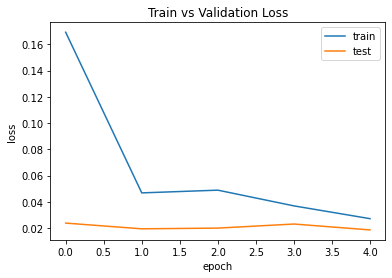

In [48]:
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title("Train vs Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(False)
plt.legend(['train', 'test'], loc='upper right')

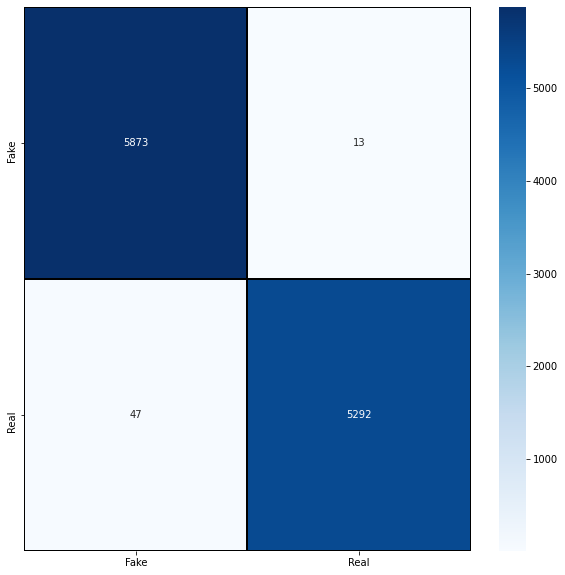

In [50]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
pred = model.predict_classes(X_test)
cm = confusion_matrix(y_test,pred)
cm = pd.DataFrame(cm , index = ['Fake','Real'] , columns = ['Fake','Real'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Real'] , yticklabels = ['Fake','Real'])


